# Abstract 

### Proiectul a vizat clasificarea calității vinului utilizând algoritmul Ridge Classifier aplicat asupra caracteristicilor fizico-chimice. Seturile de date au inclus 4.899 de probe de vin alb și 1.600 de vin roșu, fiecare cu variabile precum aciditate fixă și volatilă, acid citric, zahăr rezidual, cloruri, dioxid de sulf, densitate, pH, sulfați și alcool. Calitatea a fost etichetată în trei categorii: low (3–4), medium (5–6) și high (7–9). Datele au fost împărțite 80% pentru antrenare și 20% pentru testare. 

### Ridge Classifier a fost ales pentru capacitatea de regularizare L2, penalizând coeficienții mari și reducând varianța estimărilor, ceea ce stabilizează modelul, prevenind overfitt-ul, dar și gestionarea a corelațiilor dintre variabile. De asemenea, calitatea vinului a fost etichetată ca low, medium și high, iar RidgeClassifier funcționează bine pentru probleme de clasificare multiclasă și poate fi eficient ca o extensie a regresiei liniar-penalizate. 

### Modelul final a demonstrat că proprietățile fizico-chimice pot prezice eficient nivelul calității vinului.

# Exploratory Data Analysis (EDA) – Verificarea calității vinului alb

### Codul încarcă datele despre calitatea vinului din fișiere CSV de antrenare și testare, apoi grupează scorurile calității (quality) în trei categorii: low (3–4), medium (5–6) și high (7–8-9). După afișarea distribuției acestor grupuri în seturile de date, se separă variabilele independente (X) de etichetele de clasificare (y). Datele sunt standardizate cu StandardScaler pentru a avea medie 0 și deviație standard 1, astfel încât toate caracteristicile să fie pe aceeași scară numerică. Apoi, se antrenează un model de clasificare RidgeClassifier cu regularizare L2 (alpha=1.0), care se potrivește pe datele de antrenament scalate și apoi prezice categoriile de calitate pentru datele de test. La final, codul calculează și afișează acuratețea globală a modelului pe setul de test și un raport de clasificare detaliat care include precizia, recall-ul și scorul F1 pentru fiecare categorie ("low", "medium", "high").

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections
from sklearn.model_selection import train_test_split

## Funcția de grupare a etichetelor "quality"

In [2]:
# Citește vinul alb
white_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
white_df = pd.read_csv(white_url, sep=";")

print("White wine shape:", white_df.shape)
print(white_df.head())

White wine shape: (4898, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5   

In [3]:
print("Valori lipsă pe coloană:\n", white_df.isnull().sum())
print("Număr rânduri duplicate:", white_df.duplicated().sum())

Valori lipsă pe coloană:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Număr rânduri duplicate: 937


In [4]:
white_df = white_df.drop_duplicates()

In [5]:
# Split în train/test (80/20)
train_white, test_white = train_test_split(
    white_df,
    test_size=0.2,
    random_state=42,
    stratify=white_df["quality"]
)

# Verificăm dimensiuni
print("Train shape:", train_white.shape)
print("Test shape:", test_white.shape)

# Distribuția etichetelor
print("Train distribution:\n", train_white["quality"].value_counts().sort_index())
print("Test distribution:\n", test_white["quality"].value_counts().sort_index())

Train shape: (3168, 12)
Test shape: (793, 12)
Train distribution:
 quality
3      16
4     122
5     940
6    1430
7     551
8     105
9       4
Name: count, dtype: int64
Test distribution:
 quality
3      4
4     31
5    235
6    358
7    138
8     26
9      1
Name: count, dtype: int64


In [6]:

def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

## Distribuția datelor în seturile de antrenare și testare


In [7]:
train_white["quality_group"] = train_white["quality"].apply(map_quality)
test_white["quality_group"] = test_white["quality"].apply(map_quality)
print("Distribuție train:")
print(train_white["quality_group"].value_counts())
print("\nDistribuție test:")
print(test_white["quality_group"].value_counts())

Distribuție train:
quality_group
medium    2370
high       660
low        138
Name: count, dtype: int64

Distribuție test:
quality_group
medium    593
high      165
low        35
Name: count, dtype: int64


In [8]:
numeric_df = train_white.select_dtypes(include="number")
desc_stats = numeric_df.describe().T
desc_stats_rounded = desc_stats.round(3)
print(desc_stats_rounded)

                       count     mean     std     min      25%      50%  \
fixed acidity         3168.0    6.847   0.875   3.800    6.300    6.800   
volatile acidity      3168.0    0.281   0.104   0.080    0.210    0.260   
citric acid           3168.0    0.335   0.122   0.000    0.270    0.320   
residual sugar        3168.0    5.886   4.748   0.600    1.600    4.700   
chlorides             3168.0    0.046   0.024   0.009    0.035    0.042   
free sulfur dioxide   3168.0   34.942  17.378   2.000   23.000   33.000   
total sulfur dioxide  3168.0  137.471  42.993  18.000  107.000  133.000   
density               3168.0    0.994   0.003   0.987    0.992    0.994   
pH                    3168.0    3.196   0.151   2.720    3.100    3.180   
sulphates             3168.0    0.490   0.114   0.230    0.410    0.480   
alcohol               3168.0   10.586   1.217   8.000    9.500   10.400   
quality               3168.0    5.855   0.891   3.000    5.000    6.000   

                        

In [9]:
X_train = train_white.drop(["quality", "quality_group"], axis=1)
y_train = train_white["quality_group"]

X_test = test_white.drop(["quality", "quality_group"], axis=1)
y_test = test_white["quality_group"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Rezultatele modelului

In [10]:
model = RidgeClassifier(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.43%

Classification Report:
              precision    recall  f1-score   support

        high       0.71      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.97      0.87       593

    accuracy                           0.77       793
   macro avg       0.49      0.40      0.40       793
weighted avg       0.73      0.77      0.72       793



c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Matricea de confuzie

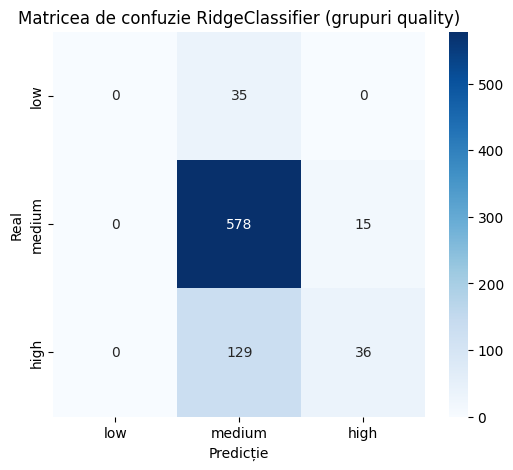

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"]
)
plt.xlabel("Predicție")
plt.ylabel("Real")
plt.title("Matricea de confuzie RidgeClassifier (grupuri quality)")
plt.show()



In [12]:
print(model.classes_)

print(train_white["quality"].value_counts().sort_index())
print(test_white["quality"].value_counts().sort_index())

['high' 'low' 'medium']
quality
3      16
4     122
5     940
6    1430
7     551
8     105
9       4
Name: count, dtype: int64
quality
3      4
4     31
5    235
6    358
7    138
8     26
9      1
Name: count, dtype: int64


## Importanța caracteristicilor pentru modelul RidgeClassifier

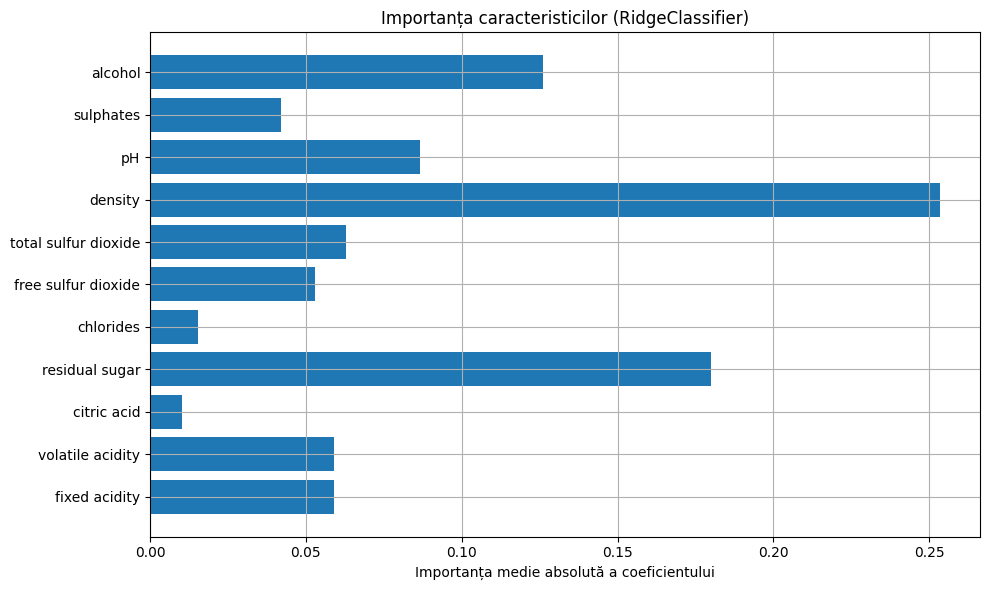

In [13]:
# Media absolută a coeficienților pe fiecare caracteristică
mean_abs_coefs = np.mean(np.abs(model.coef_), axis=0)

# Numele caracteristicilor
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10,6))
plt.barh(feature_names, mean_abs_coefs)
plt.xlabel("Importanța medie absolută a coeficientului")
plt.title("Importanța caracteristicilor (RidgeClassifier)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Distribuția predicțiilor

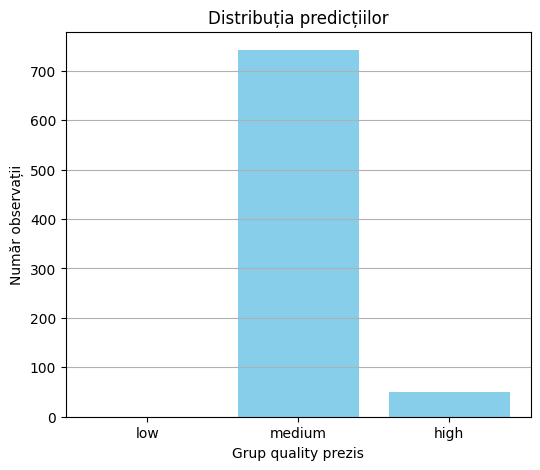

In [14]:
# Numărăm predicțiile
pred_counts = collections.Counter(y_pred)

# Asigurăm ordinea consistentă
labels = ["low", "medium", "high"]
counts = [pred_counts.get(label, 0) for label in labels]

# Plot
plt.figure(figsize=(6,5))
plt.bar(labels, counts, color="skyblue")
plt.xlabel("Grup quality prezis")
plt.ylabel("Număr observații")
plt.title("Distribuția predicțiilor")
plt.grid(True, axis="y")
plt.show()

## Distribuția reală vs. prezisă

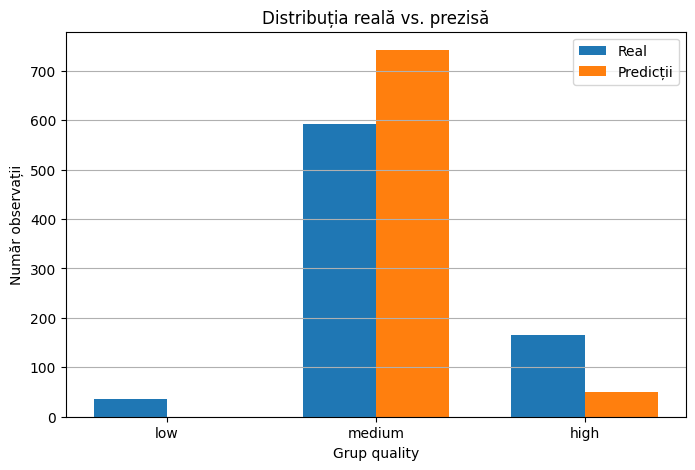

In [15]:
# Numărăm etichetele reale
real_counts = collections.Counter(y_test)

real_counts_values = [real_counts.get(label, 0) for label in labels]

# Plot comparativ
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, real_counts_values, width, label="Real")
plt.bar(x + width/2, counts, width, label="Predicții")
plt.xticks(x, labels)
plt.xlabel("Grup quality")
plt.ylabel("Număr observații")
plt.title("Distribuția reală vs. prezisă")
plt.legend()
plt.grid(True, axis="y")
plt.show()

## Corelații Pearson între variabile numerice și quality


Corelații Pearson între fiecare variabilă numerică și quality:
alcohol                 0.468330
pH                      0.128768
sulphates               0.051221
free sulfur dioxide     0.012942
citric acid             0.006761
residual sugar         -0.119245
fixed acidity          -0.126605
total sulfur dioxide   -0.185490
volatile acidity       -0.191733
chlorides              -0.213573
density                -0.350398
Name: quality, dtype: float64


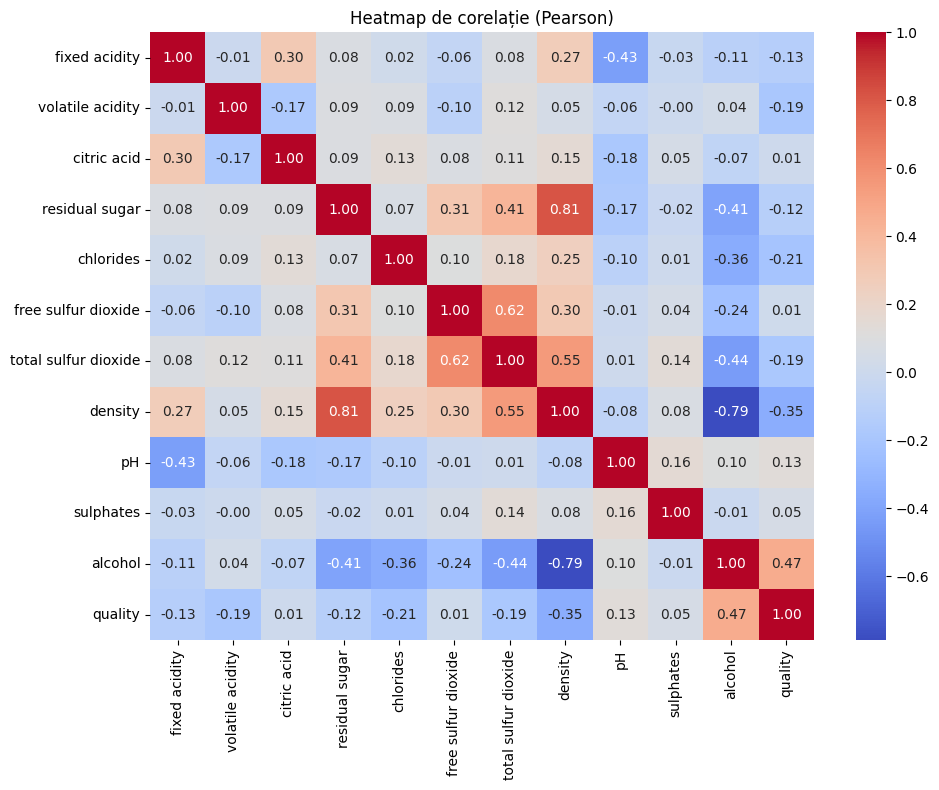

In [16]:

numeric_df = train_white.select_dtypes(include='number')

# Calculează corelația cu quality
correlations = numeric_df.corr()['quality'].drop('quality').sort_values(ascending=False)

print("\nCorelații Pearson între fiecare variabilă numerică și quality:")
print(correlations)

# Heatmap complet al corelațiilor
plt.figure(figsize=(10,8))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Heatmap de corelație (Pearson)")
plt.tight_layout()
plt.show()

### Alcohol (+0.47): Cea mai puternică corelație pozitivă. Cu cât alcoolul e mai mare, cu atât scorul de calitate e mai mare și nu e surprinzător: vinurile cu tărie mai mare tind să fie considerate mai bune.
### pH (+0.13): O corelație pozitivă slabă, dar care sugerează că un pH mai mare poate(mai puțin acid) fi asociat cu o calitate mai bună.
### Sulphates (+0.05): Corelație foarte slab pozitivă. Sulfații contribuie la stabilitate și conservare, dar efectul e mic.
### Free sulfur oxide(0.01): Cantitate neglijabilă în privința calității.
### Citric acid(0.006): Cantitate neglijabilă în privința calității.
### Density (–0.35): Corelație negativă. Vinurile mai dense tind să fie de calitate mai slabă, probabil pentru că densitatea mare sugerează zahăr rezidual excesiv sau fermentare incompletă.
### Chlorides (–0.21): Corelație negativă. Sarea(clorurile) ridicată în vin afectează gustul.
### Volatile acidity (–0.19): Corelație negativă. Aciditatea volatilă ridicată scade calitatea vinului, reflectând un gust acru, neplăcut.
### Total sulfur oxide (-0.19): Corelație negativă. Nivelurile mari pot afecta gustul și prospețimea.
### Fixed acidity (–0.13): Corelație negativă slabă. Aciditatea mai mare poate indica un gust mai acru, ceea ce nu e ideal pentru calitate.
### Residual sugar(-0.12): Cantitatea mare de zahăr rezidual tinde ușor să scadă calitatea.



## Histograme pentru toate variabilele numerice

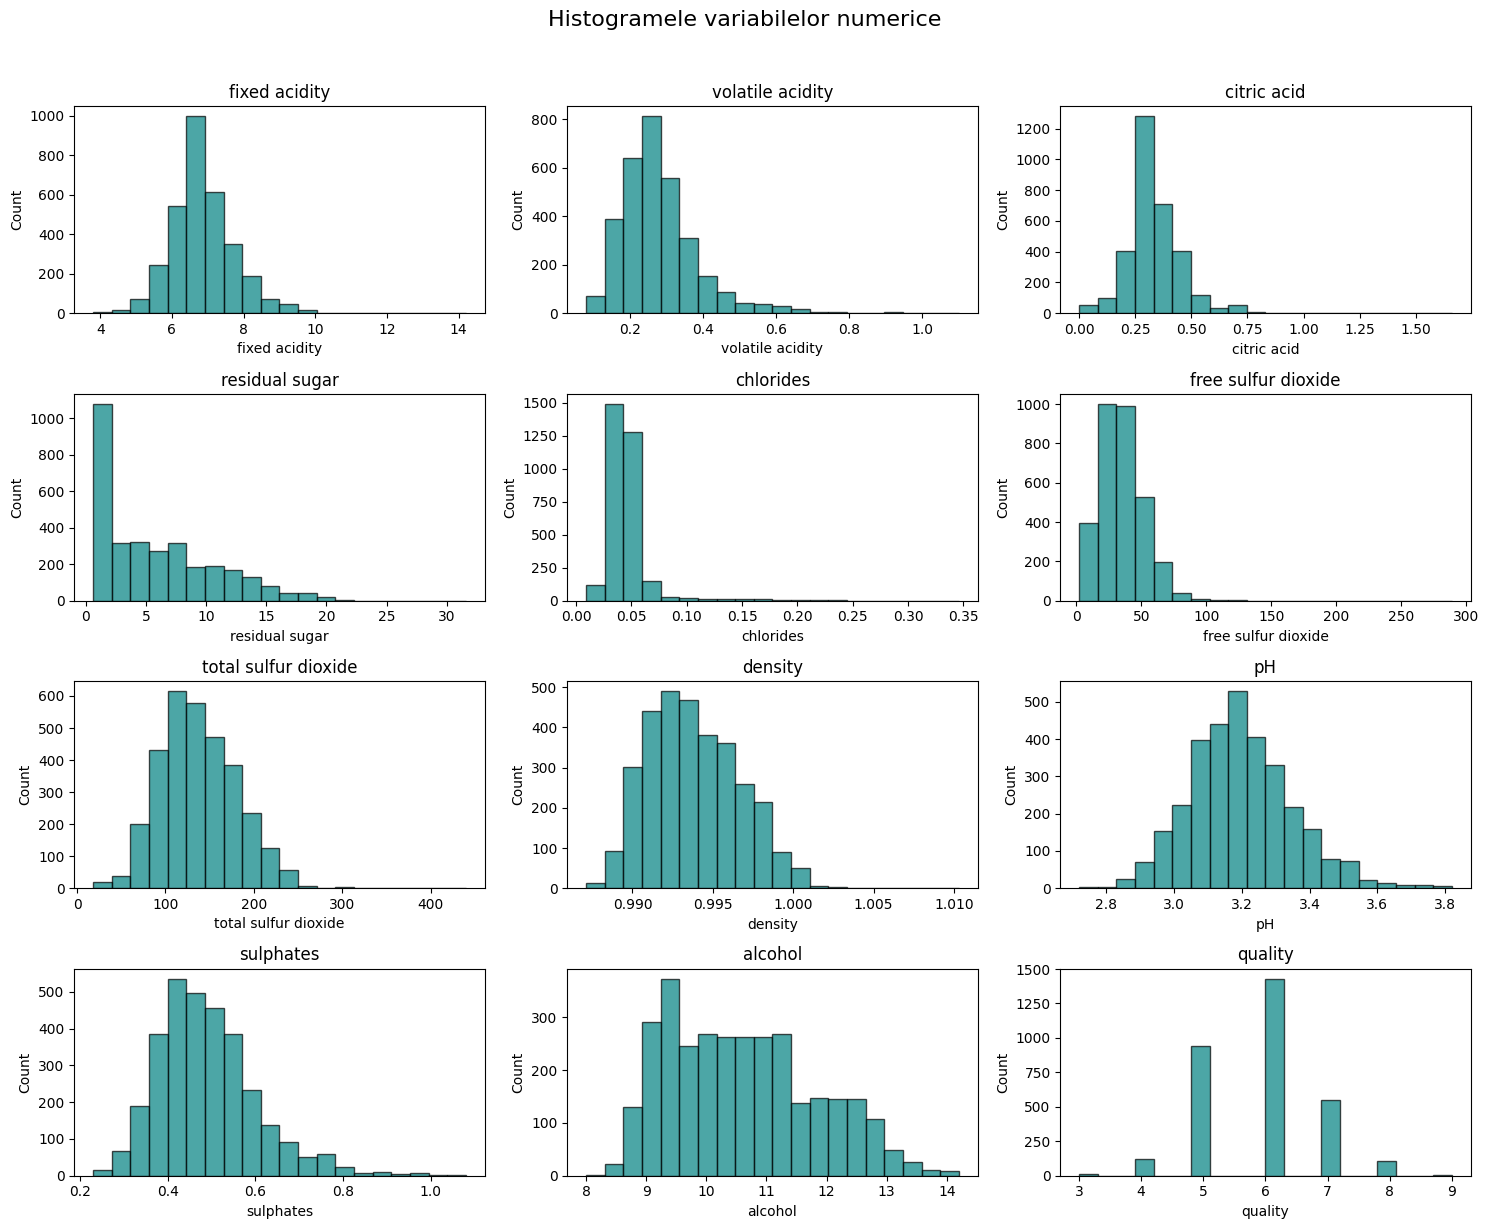

In [17]:

numeric_columns = train_white.select_dtypes(include='number').columns

# Setăm un grid de subploturi
num_vars = len(numeric_columns)
cols = 3
rows = (num_vars // cols) + int(num_vars % cols > 0)

plt.figure(figsize=(cols * 5, rows * 3))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(rows, cols, i)
    plt.hist(train_white[col], bins=20, color='teal', edgecolor='black', alpha=0.7)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.suptitle("Histogramele variabilelor numerice", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Alte încercări

### Mai sus a fost prezentat modelul de bază. În alte fișiere ipynb, au fost încercate alte metode a îmbunătăți modelul, precum: optimizarea hiperparametrilor, de a mări complexitatea modelului, deoarece modelul nu putea prezice clasa low(quality 3-4), dar și implementarea ADASYN, o metodă de a genera date în clasele „rare”.

### RidgeClassifier: Acest clasificator convertește mai întâi valorile țintă în {-1, 1}, apoi tratează problema ca o sarcină de regresie (regresie multi-output în cazul multi-clasă). 

##### alpha (float, implicit=1.0): puterea regularizării, trebuie să fie un număr pozitiv. Regularizarea îmbunătățește condiționarea problemei și reduce varianța estimărilor. Valorile mai mari indică o regularizare mai puternică. 

##### class_weight(dict sau ‘balanced’,implicit=None): ponderile asociate claselor, sub forma {eticheta_clasei: pondere}. Dacă nu se specifică, toate clasele sunt considerate cu pondere egală (1). Modul „balanced” folosește valorile lui y pentru a ajusta automat ponderile invers proporțional cu frecvența claselor în datele de intrare, conform:n_samples / (n_classes * np.bincount(y))


#### model = RidgeClassifier(alpha=1.0)

Acuratețea modelului RidgeClassifier pe grupuri: 76.22%

Classification Report:
              precision    recall  f1-score   support

        high       0.67      0.20      0.31       227
         low       0.00      0.00      0.00        30
      medium       0.77      0.97      0.86       723

    accuracy                           0.76       980
   macro avg       0.48      0.39      0.39       980
weighted avg       0.72      0.76      0.70       980



model = RidgeClassifier(alpha=5.0, class_weight='balanced')
Acuratețea modelului RidgeClassifier pe grupuri: 50.82%

Classification Report:
              precision    recall  f1-score   support

        high       0.42      0.76      0.54       227
         low       0.08      0.57      0.14        30
      medium       0.87      0.43      0.57       723

    accuracy                           0.51       980
   macro avg       0.46      0.58      0.42       980
weighted avg       0.74      0.51      0.55       980



model = RidgeClassifier(alpha=10.0)
Acuratețea modelului RidgeClassifier pe grupuri: 75.92%

Classification Report:
              precision    recall  f1-score   support

        high       0.65      0.19      0.29       227
         low       0.00      0.00      0.00        30
      medium       0.77      0.97      0.86       723

    accuracy                           0.76       980
   macro avg       0.47      0.39      0.38       980
weighted avg       0.72      0.76      0.70       980


model = RidgeClassifier(alpha=5.0, fit_intercept=True, solver='sag', random_state=42)
Acuratețea modelului RidgeClassifier pe grupuri: 76.22%

Classification Report:
              precision    recall  f1-score   support

        high       0.67      0.20      0.31       227
         low       0.00      0.00      0.00        30
      medium       0.77      0.97      0.86       723

    accuracy                           0.76       980
   macro avg       0.48      0.39      0.39       980
weighted avg       0.72      0.76      0.70       980

## Încercare ADASYN


### ADASYN (Suprasampling utilizând algoritmul Adaptive Synthetic): Această metodă este similară cu SMOTE, dar generează un număr diferit de exemple sintetice în funcție de o estimare a distribuției locale a clasei care trebuie suprasamplată.

##### n_neighbors (int sau obiect estimator, implicit=5): numărul de vecini apropiați folosiți pentru a defini vecinătatea eșantioanelor utilizate în generarea noilor exemple sintetice.

##### sampling_strategy (float, str, dict sau callable, implicit=’auto’). Informații despre modul de resampling al setului de date: 
##### •	'minority': resamplează doar clasa minoritară;
##### •	'not minority': resamplează toate clasele cu excepția clasei minoritare;
##### •	'not majority': resamplează toate clasele cu excepția clasei majoritare;
##### •	'all': resamplează toate clasele;
##### •	'auto': echivalent cu 'not majority'.



#### model = RidgeClassifier(alpha=10.0, fit_intercept=True, solver='auto', random_state=42)
adasyn = ADASYN(random_state=42)
Distribuție după ADASYN:
Counter({'low': 2950, 'medium': 2932, 'high': 2845})

Acuratețea modelului RidgeClassifier cu ADASYN: 50.41%

Classification Report:
              precision    recall  f1-score   support

        high       0.42      0.78      0.55       227
         low       0.09      0.63      0.15        30
      medium       0.87      0.41      0.56       723
...
    accuracy                           0.50       980
   macro avg       0.46      0.61      0.42       980
weighted avg       0.74      0.50      0.54       980

model = RidgeClassifier(alpha=10.0, fit_intercept=True, solver='auto', random_state=42)
adasyn = ADASYN(random_state=42, sampling_strategy="minority")
Distribuție după ADASYN:
Counter({'low': 2950, 'medium': 2932, 'high': 833})

Acuratețea modelului RidgeClassifier cu ADASYN: 57.24%

Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.09      0.16       227
         low       0.08      0.67      0.15        30
      medium       0.73      0.72      0.72       723
...
    accuracy                           0.57       980
   macro avg       0.53      0.49      0.34       980
weighted avg       0.72      0.57      0.58       980

model = RidgeClassifier(alpha=10.0, fit_intercept=True, solver='auto', random_state=42)
adasyn = ADASYN(random_state=42, sampling_strategy="all")
Distribuție după ADASYN:
Counter({'low': 2950, 'medium': 2932, 'high': 2845})

Acuratețea modelului RidgeClassifier cu ADASYN: 50.41%

Classification Report:
              precision    recall  f1-score   support

        high       0.42      0.78      0.55       227
         low       0.09      0.63      0.15        30
      medium       0.87      0.41      0.56       723
...
    accuracy                           0.50       980
   macro avg       0.46      0.61      0.42       980
weighted avg       0.74      0.50      0.54       980

# Exploratory Data Analysis (EDA) – Verificarea calității vinului roșu

### Codul încarcă datele despre calitatea vinului roșu din fișierul CSV, verifică și elimină rândurile duplicate, apoi grupează scorurile de calitate în trei categorii („low”, „mediu” și „high”) folosind o funcție de mapare. Variabilele independente (caracteristicile chimice ale vinului) sunt standardizate cu StandardScaler, iar datele sunt împărțite în seturi de antrenament și testare (80/20) cu stratificare pentru a păstra distribuția claselor. Codul afișează distribuția scorurilor originale și a categoriilor grupate prin contorizare și un grafic cu bare. Se antrenează un model de clasificare RidgeClassifier, se fac predicții asupra setului de test, iar performanța modelului este evaluată prin acuratețe și un raport de clasificare detaliat.


In [18]:

# Importăm librăriile necesare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Colectarea și procesarea datelor

In [19]:
# Citește vinul roșu
red_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
red_df = pd.read_csv(red_url, sep=";")

# Verificăm datele
print("Red wine shape:", red_df.shape)

# Primele rânduri
print(red_df.head())


Red wine shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8     

In [20]:
print("Valori lipsă pe coloană:\n", red_df.isnull().sum())
print("Număr rânduri duplicate:", red_df.duplicated().sum())


Valori lipsă pe coloană:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Număr rânduri duplicate: 240


In [21]:
red_df = red_df.drop_duplicates()

In [22]:
# Split în train/test (80/20), stratificat după quality
train_red, test_red = train_test_split(
    red_df,
    test_size=0.2,
    random_state=42,
    stratify=red_df["quality"]
)


In [23]:
# Verificăm dimensiuni
print("Train shape:", train_red.shape)
print("Test shape:", test_red.shape)

# Distribuția etichetelor
print("Distribuție train:\n", train_red["quality"].value_counts().sort_index())
print("Distribuție test:\n", test_red["quality"].value_counts().sort_index())

Train shape: (1087, 12)
Test shape: (272, 12)
Distribuție train:
 quality
3      8
4     42
5    461
6    428
7    134
8     14
Name: count, dtype: int64
Distribuție test:
 quality
3      2
4     11
5    116
6    107
7     33
8      3
Name: count, dtype: int64


In [24]:

# Grupăm calitatea în low, mediu, high
def map_quality(value):
    if value <= 4:
        return "low"
    elif value <= 6:
        return "mediu"
    else:
        return "high"

In [25]:

# Aplicăm gruparea
train_red["quality_group"] = train_red["quality"].apply(map_quality)
test_red["quality_group"] = test_red["quality"].apply(map_quality)

print("\nDistribuție grup train:\n", train_red["quality_group"].value_counts())
print("\nDistribuție grup test:\n", test_red["quality_group"].value_counts())





Distribuție grup train:
 quality_group
mediu    889
high     148
low       50
Name: count, dtype: int64

Distribuție grup test:
 quality_group
mediu    223
high      36
low       13
Name: count, dtype: int64


## Explorarea datelor

In [26]:
X_train = train_red.drop(columns=['quality', 'quality_group'])
y_train = train_red['quality_group']

X_test = test_red.drop(columns=['quality', 'quality_group'])
y_test = test_red['quality_group']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Distribuție scor original
print(train_red['quality'].value_counts())

# Distribuție calitate grupată
grouped_counts = train_red['quality_group'].value_counts().sort_index()
print("Distribuție scoruri grupate:\n", grouped_counts)


quality
5    461
6    428
7    134
4     42
8     14
3      8
Name: count, dtype: int64
Distribuție scoruri grupate:
 quality_group
high     148
low       50
mediu    889
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14820\1712105284.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_counts.index, y=grouped_counts.values, palette="pastel")


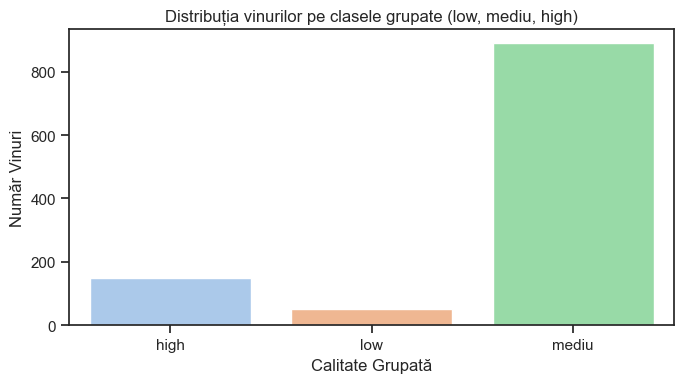

In [28]:

# Barplot scor grupat
plt.figure(figsize=(7, 4))
sns.barplot(x=grouped_counts.index, y=grouped_counts.values, palette="pastel")
plt.title("Distribuția vinurilor pe clasele grupate (low, mediu, high)")
plt.xlabel("Calitate Grupată")
plt.ylabel("Număr Vinuri")
plt.tight_layout()
plt.show()


## Histograme pentru variabile

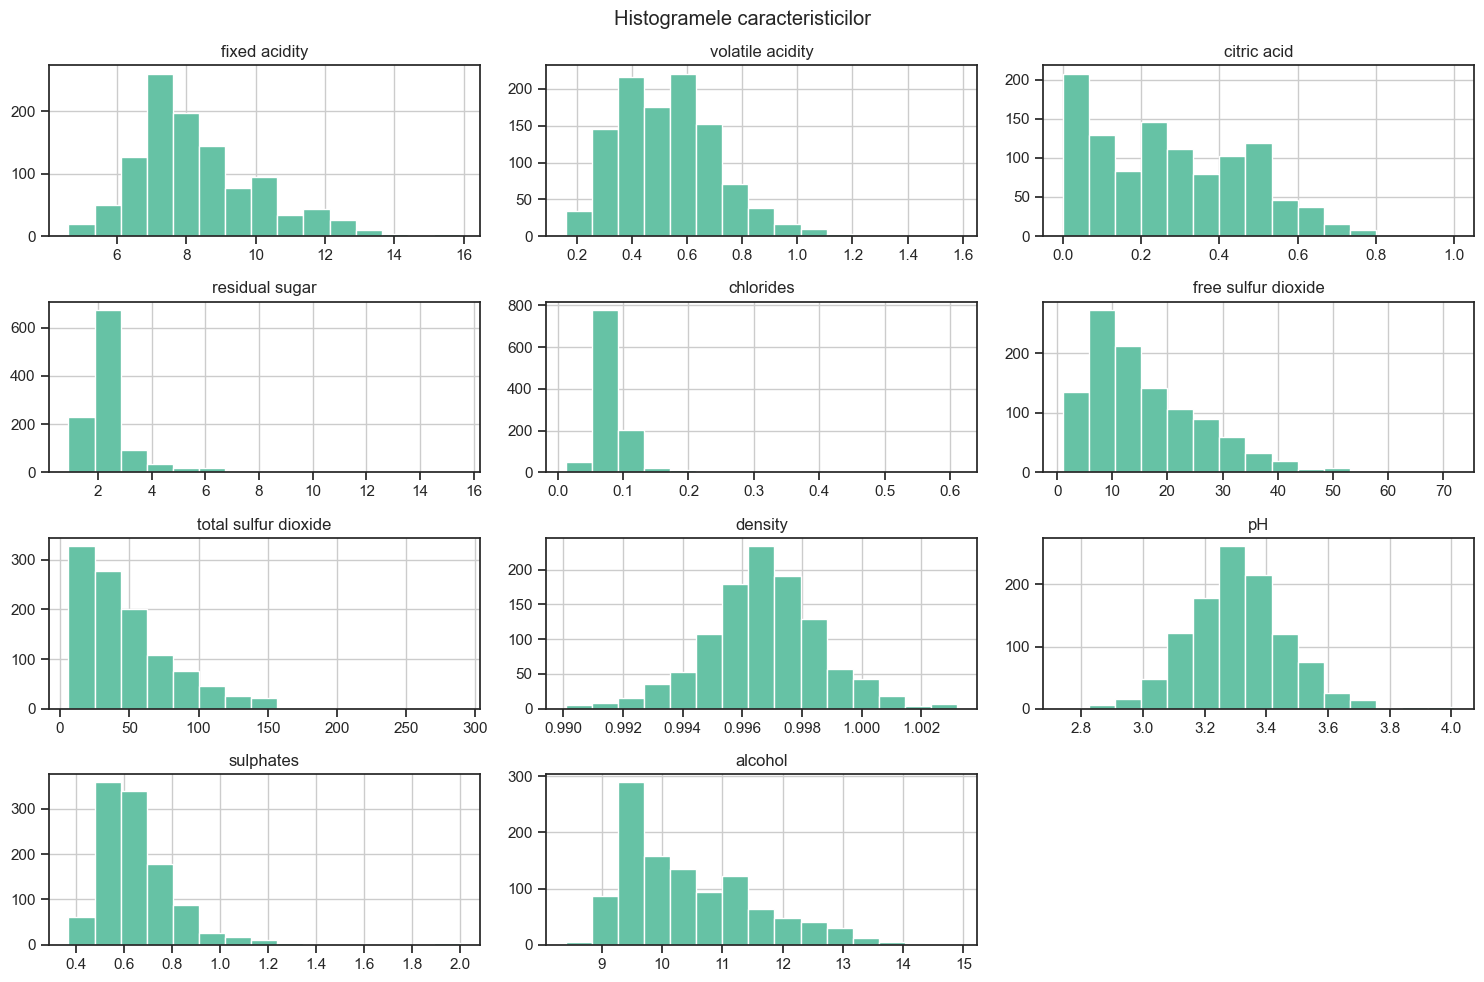

In [29]:
train_red.drop(columns=['quality', 'quality_group']).hist(bins=15, figsize=(15, 10))
plt.suptitle("Histogramele caracteristicilor")
plt.tight_layout()
plt.show()

## Boxploturi pentru outlieri

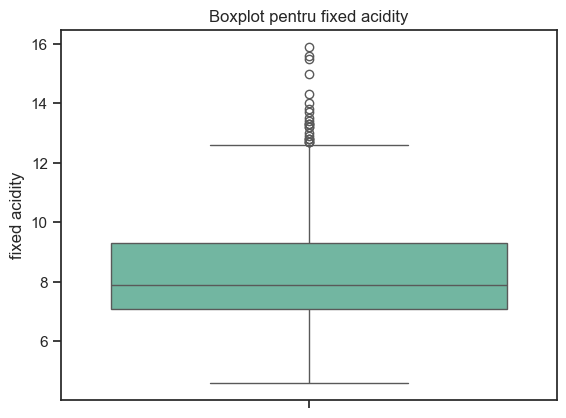

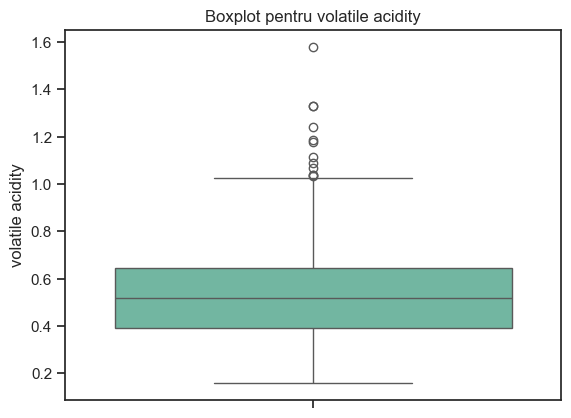

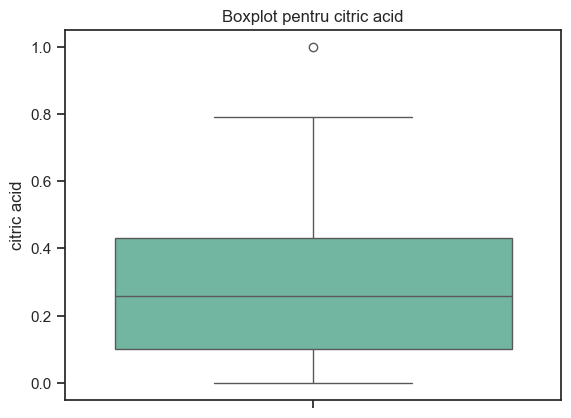

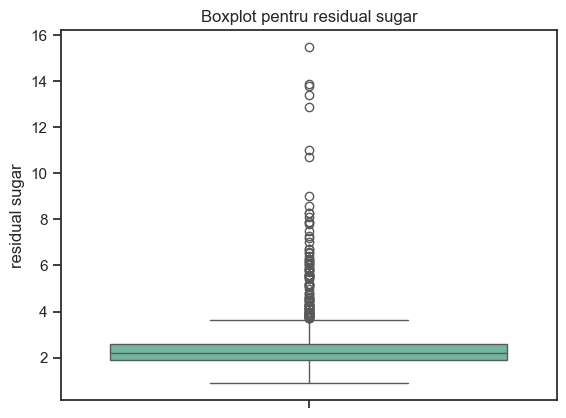

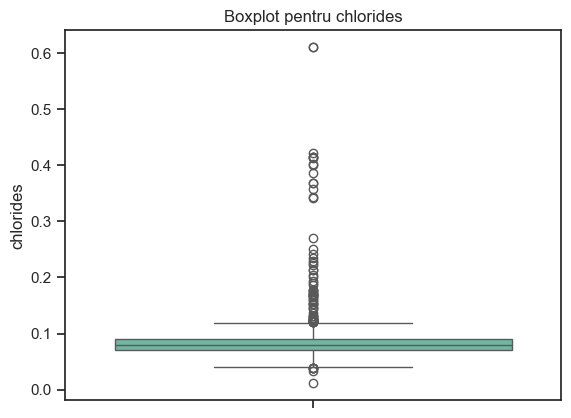

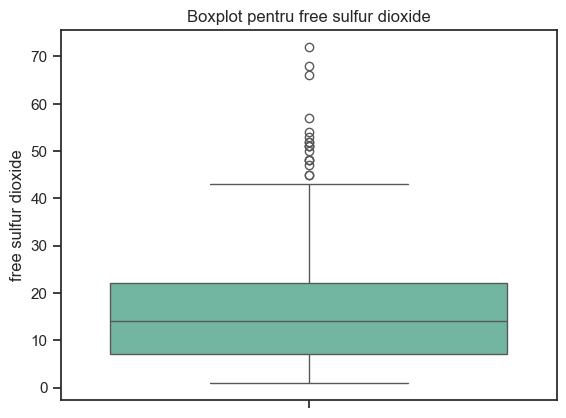

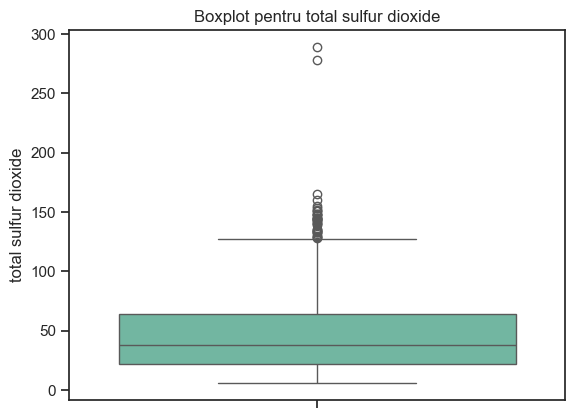

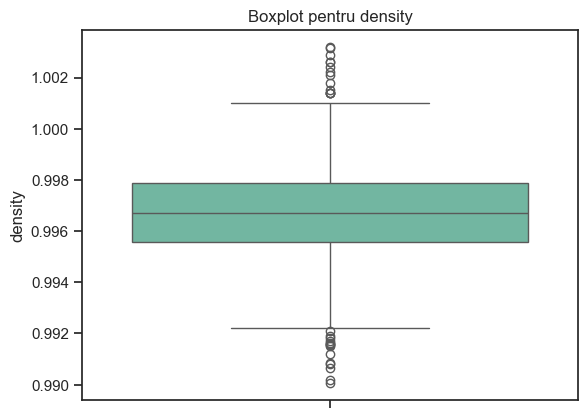

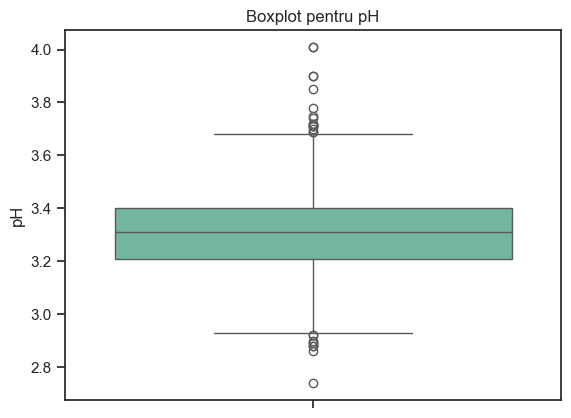

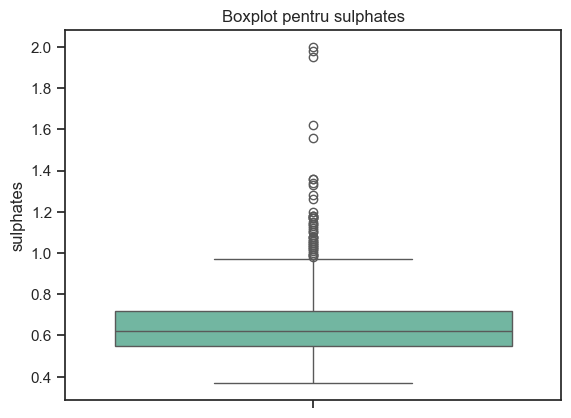

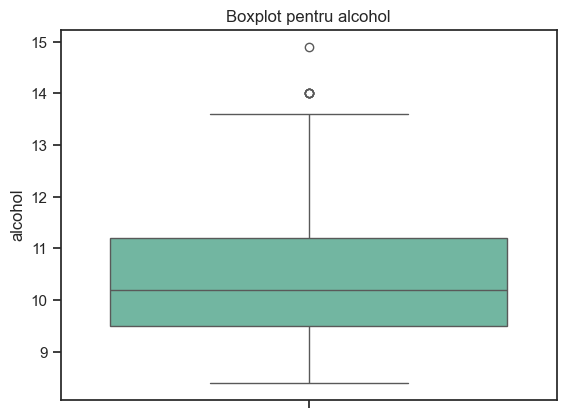

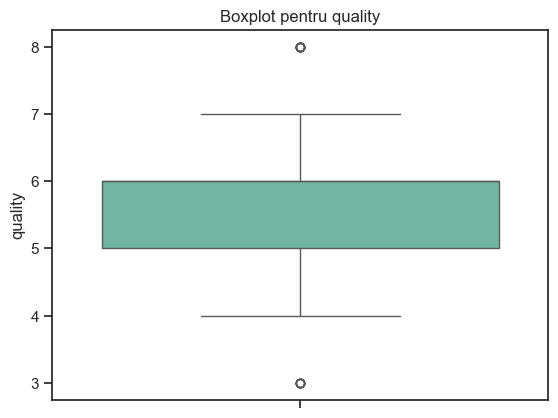

In [30]:

for col in train_red.select_dtypes(include='number').columns:
    sns.boxplot(y=train_red[col])
    plt.title(f'Boxplot pentru {col}')
    plt.show()


In [31]:

# Model RidgeClassifier
model = RidgeClassifier()
model.fit(X_train, y_train)

# Predicții
y_pred = model.predict(X_test)

print("Acuratețe:", accuracy_score(y_test, y_pred))
print("Raport de clasificare:\n", classification_report(y_test, y_pred, zero_division=0))



Acuratețe: 0.8198529411764706
Raport de clasificare:
               precision    recall  f1-score   support

        high       0.50      0.06      0.10        36
         low       0.00      0.00      0.00        13
       mediu       0.82      0.99      0.90       223

    accuracy                           0.82       272
   macro avg       0.44      0.35      0.33       272
weighted avg       0.74      0.82      0.75       272



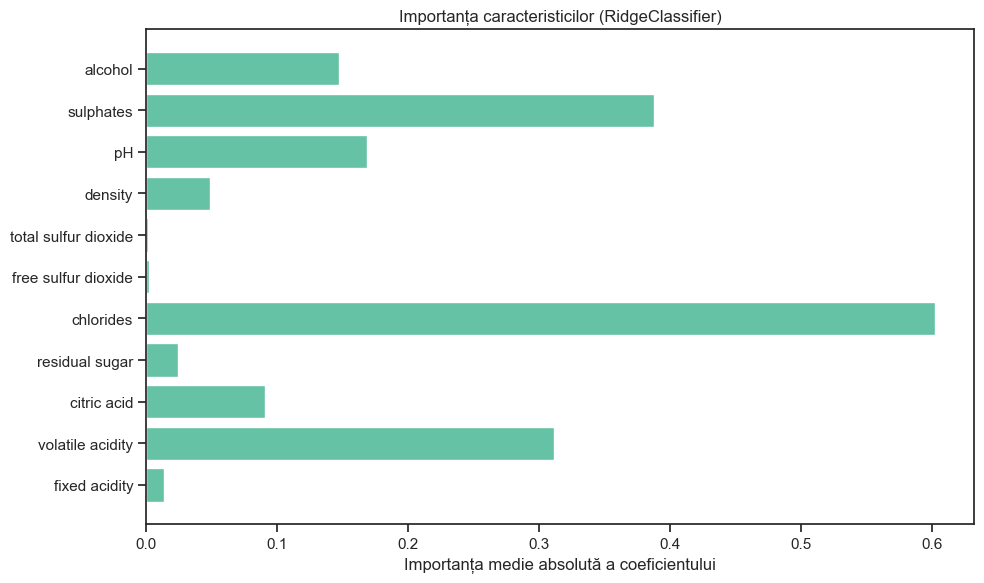

In [32]:
# Importanță caracteristici
importance = np.abs(model.coef_).mean(axis=0)
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Importanța medie absolută a coeficientului")
plt.title("Importanța caracteristicilor (RidgeClassifier)")
plt.tight_layout()
plt.show()

alcohol                 0.472495
sulphates               0.261085
citric acid             0.243658
fixed acidity           0.119490
residual sugar         -0.014120
free sulfur dioxide    -0.032008
pH                     -0.055011
chlorides              -0.124486
total sulfur dioxide   -0.165412
density                -0.184460
volatile acidity       -0.397074
Name: quality, dtype: float64


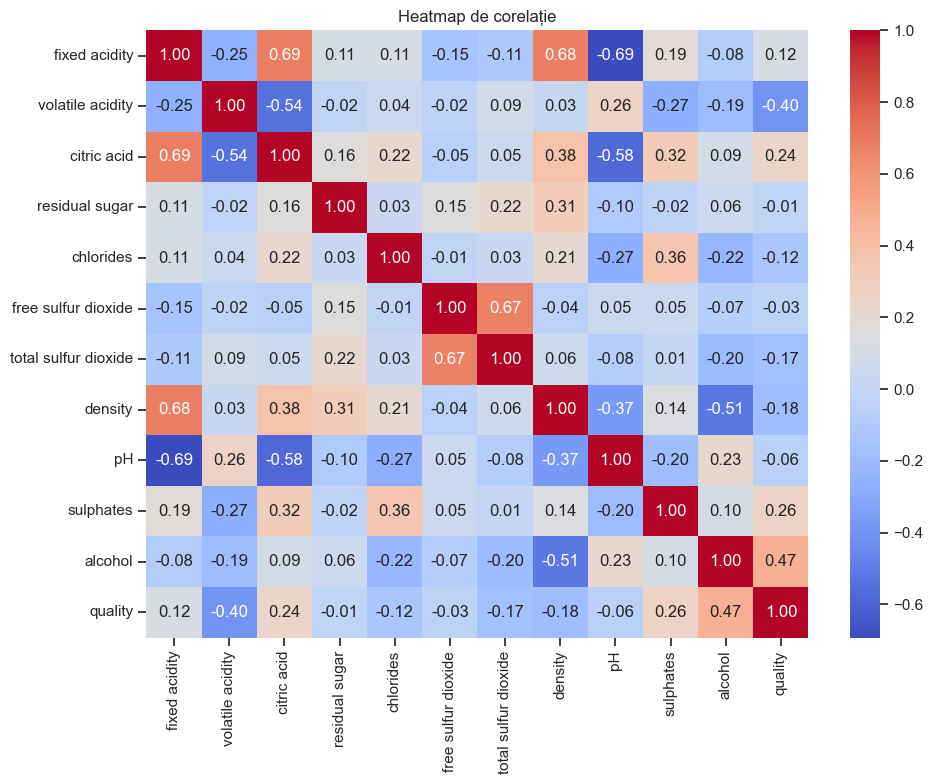

In [33]:

# Corelații numerice
numerice_df = train_red.select_dtypes(include='number')
correlations = numerice_df.corr()['quality'].drop('quality').sort_values(ascending=False)
print(correlations)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerice_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de corelație")
plt.tight_layout()
plt.show()

## Corelații pozitive (când crește variabila, crește și calitatea):
### Alcohol (0.47) – Vinurile cu mai mult alcool sunt, în general, considerate de calitate mai bună.

### Sulphates (0.25) – Sulfații contribuie la stabilitatea vinului și sunt asociați cu scoruri mai bune.

### Citric acid (0.24) – O ușoară aciditate adaugă prospețime și e apreciată în vinurile bune.

### Fixed acidity (0.12) – Are o influență slabă, dar pozitivă asupra gustului.

## Corelații negative (când crește variabila, scade calitatea):

### Residual sugar (-0.01) – Nu pare sa aibă o legatură clară cu scorul calității.

### Free sulfur dioxide (-0.05) – Efect foarte mic, dar în cantitate prea mare poate afecta gustul.

### pH (-0.06) – Un pH mai scăzut poate fi mai bun, dar influența generală este foarte redusă.

### Chlorides (-0.12) – Clorurile pot da un gust sărat și apar mai des in vinurile mai slabe.

### Total sulfur dioxide (-0.17) – Nivelurile ridicate pot strica aroma și sunt asociate cu scoruri mai mici.

### Density (-0.18) – Vinurile mai dense (de obicei mai dulci) tind sa fie cotate mai slab.

### Volatile acidity (-0.40) – Are cea mai puternică legatură negativă, aciditatea volatilă mare e percepută ca defect (gust înțepător, miros de oțet).


In [34]:

# PCA
X_pca = numerice_df.drop(columns=["quality"])
X_scaled = StandardScaler().fit_transform(X_pca)

pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# SelectKBest
y_num = numerice_df["quality"]
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_pca, y_num)
scores = pd.Series(selector.scores_, index=X_pca.columns)
print("Cele mai relevante variabile:\n", scores.sort_values(ascending=False))

Explained variance ratio: [0.28733805 0.1719102  0.14262364]
Cele mai relevante variabile:
 alcohol                 80.409734
volatile acidity        44.453957
sulphates               16.956680
total sulfur dioxide    16.273450
citric acid             14.782937
density                 10.388594
fixed acidity            4.802914
pH                       3.988379
free sulfur dioxide      3.855237
chlorides                3.732912
residual sugar           1.388507
dtype: float64


# Optimizarea performantelor modelului - Red Wine

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [36]:
red_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
red_df = pd.read_csv(red_url, sep=";")

In [37]:
def grupare_calitate(x):
    if x <= 4:
        return "slab"
    elif x <= 6:
        return "mediu"
    else:
        return "bun"

In [38]:
# Adaugă eticheta grupată
red_df["calitate"] = red_df["quality"].apply(grupare_calitate)

# Separă variabilele
X = red_df.drop(columns=["quality", "calitate"])
y = red_df["calitate"]

# Split train/test stratificat
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### GridSearchCV: Căutare asupra valorilor specificate ale parametrilor pentru un estimator.
### GridSearchCV implementează metodele fit și score. De asemenea, implementează metodele score_samples, predict, predict_proba, decision_function, transform și inverse_transform, dacă acestea sunt implementate în estimatorul utilizat.
##### Pentru fiecare model (RidgeClassifier, RandomForestClassifier și GradientBoostingClassifier) se definește o grilă de hiperparametri și se utilizează GridSearchCV cu validare încrucișată pe 5 fold-uri pentru a găsi combinația de parametri care maximizează acuratețea. Modelul optim găsit este evaluat pe setul de testare, iar rezultatele includ cea mai bună configurare a hiperparametrilor, acuratețea finală și raportul de clasificare (precizie, recall și F1-score pentru fiecare clasă). Astfel, scriptul compară direct cele trei algoritmi și selectează configurațiile lor cele mai performante.

In [39]:
model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeClassifier())
])

parametri_ridge = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(model_ridge, parametri_ridge, cv=5, scoring="accuracy")
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.best_estimator_.predict(X_test)

print("=== RidgeClassifier ===")
print("Cea mai buna valoare alpha:", grid_ridge.best_params_["ridge__alpha"])
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_ridge), 4))
print(classification_report(y_test, y_pred_ridge, zero_division=0))

=== RidgeClassifier ===
Cea mai buna valoare alpha: 10
Acuratete pe setul de test: 0.8313
              precision    recall  f1-score   support

         bun       0.60      0.14      0.23        43
       mediu       0.84      0.98      0.91       264
        slab       0.00      0.00      0.00        13

    accuracy                           0.83       320
   macro avg       0.48      0.37      0.38       320
weighted avg       0.77      0.83      0.78       320



In [40]:
parametri_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), parametri_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.best_estimator_.predict(X_test)

print("=== RandomForestClassifier ===")
print("Cei mai buni parametri:", grid_rf.best_params_)
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf, zero_division=0))

=== RandomForestClassifier ===
Cei mai buni parametri: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Acuratete pe setul de test: 0.8688
              precision    recall  f1-score   support

         bun       0.73      0.56      0.63        43
       mediu       0.89      0.96      0.92       264
        slab       0.00      0.00      0.00        13

    accuracy                           0.87       320
   macro avg       0.54      0.51      0.52       320
weighted avg       0.83      0.87      0.85       320



### Random Forest este un meta-estimator care antrenează un număr de clasificatori de tip arbore de decizie pe diferite sub-eșantioane ale setului de date și utilizează medierea (averaging) pentru a îmbunătăți acuratețea predicțiilor și pentru a controla supraînvățarea (over-fitting). "Arborii din pădure" folosesc strategia de împărțire optimă, adică echivalentă cu transmiterea opțiunii splitter="best" către clasificatorul de tip arbore de decizie subordonat (DecisionTreeClassifier). Dimensiunea sub-eșantionului este controlată prin parametrul max_samples dacă bootstrap=True (implicit), altfel fiecare arbore este construit utilizând întregul set de date.

#### max_depth(int,implicit=None): adâncimea maximă a arborelui. Dacă este None, nodurile sunt extinse până când toate frunzele devin pure sau până când toate frunzele conțin mai puține eșantioane decât min_samples_split.

#### min_samples_split (int sau float, implicit=2): numărul minim de eșantioane necesar pentru a împărți un nod intern.

#### n_estimators (int, implicit=100): numărul de arbori din pădure.


In [41]:

parametri_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), parametri_gb, cv=5, scoring="accuracy", n_jobs=-1)
grid_gb.fit(X_train, y_train)
y_pred_gb = grid_gb.best_estimator_.predict(X_test)

print("=== GradientBoostingClassifier ===")
print("Cei mai buni parametri:", grid_gb.best_params_)
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_gb), 4))
print(classification_report(y_test, y_pred_gb, zero_division=0))


=== GradientBoostingClassifier ===
Cei mai buni parametri: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Acuratete pe setul de test: 0.8688
              precision    recall  f1-score   support

         bun       0.68      0.63      0.65        43
       mediu       0.90      0.95      0.92       264
        slab       0.50      0.08      0.13        13

    accuracy                           0.87       320
   macro avg       0.69      0.55      0.57       320
weighted avg       0.85      0.87      0.85       320



# Bibliografie

- [RidgeClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)
- [ADASYN — Version 0.13.0](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)
- [GridSearchCV — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomForestClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [GradientBoostingClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, Aurélien Geron

